<a href="https://colab.research.google.com/github/BenjaminEbanks/Analyzing-Parameter-Symmetries/blob/main/Parameter_Symmetries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Utils**

In [1]:
import copy

def flatten_params(model):
  return model.state_dict()

def lerp(lam, t1, t2):
  t3 = copy.deepcopy(t2)
  for p in t1:
    t3[p] = (1 - lam) * t1[p] + lam * t2[p]
  return t3

In [2]:
import matplotlib.pyplot as plt

def plot_interp_acc(lambdas, train_acc_interp_naive, test_acc_interp_naive,
                    train_acc_interp_clever, test_acc_interp_clever):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(lambdas,
          train_acc_interp_naive,
          linestyle="dashed",
          color="tab:blue",
          alpha=0.5,
          linewidth=2,
          label="Train, naïve interp.")
  ax.plot(lambdas,
          test_acc_interp_naive,
          linestyle="dashed",
          color="tab:orange",
          alpha=0.5,
          linewidth=2,
          label="Test, naïve interp.")
  ax.plot(lambdas,
          train_acc_interp_clever,
          linestyle="solid",
          color="tab:blue",
          linewidth=2,
          label="Train, permuted interp.")
  ax.plot(lambdas,
          test_acc_interp_clever,
          linestyle="solid",
          color="tab:orange",
          linewidth=2,
          label="Test, permuted interp.")
  ax.set_xlabel("$\lambda$")
  ax.set_xticks([0, 1])
  ax.set_xticklabels(["Model $A$", "Model $B$"])
  ax.set_ylabel("Accuracy")
  # TODO label x=0 tick as \theta_1, and x=1 tick as \theta_2
  ax.set_title(f"Accuracy between the two models")
  ax.legend(loc="lower right", framealpha=0.5)
  fig.tight_layout()
  return fig

In [3]:
from collections import defaultdict
from re import L
from typing import NamedTuple
import torch
from scipy.optimize import linear_sum_assignment



class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "layer0.weight": ("P_0", None),
      **{f"layer{i}.weight": ( f"P_{i}", f"P_{i-1}")
         for i in range(1, num_hidden_layers)},
      **{f"layer{i}.bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"layer{num_hidden_layers}.weight": (None, f"P_{num_hidden_layers-1}"),
      f"layer{num_hidden_layers}.bias": (None, ),
  })

"""
def cnn_permutation_spec() -> PermutationSpec:
  conv = lambda name, p_in, p_out: {f"{name}.weight": (p_out, p_in, None, None, )}
  dense = lambda name, p_in, p_out, bias=True: {f"{name}.weight": (p_out, p_in), f"{name}.bias": (p_out, )} if bias else  {f"{name}.weight": (p_out, p_in)}

  return permutation_spec_from_axes_to_perm({
     **conv("conv1", None, "P_bg0"),
     **conv("conv2", "P_bg0", "P_bg1"),
     **dense("fc1", "P_bg1", "P_bg2"),
     **dense("fc2", "P_bg2", None, False),
  })
"""

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
        w = torch.index_select(w, axis, perm[p].int())

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: torch.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in torch.randperm(len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = torch.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = torch.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = torch.moveaxis(w_b, axis, 0).reshape((n, -1))

        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A.detach().numpy(), maximize=True)
      assert (torch.tensor(ri) == torch.arange(len(ri))).all()
      oldL = torch.einsum('ij,ij->i', A, torch.eye(n)[perm[p].long()]).sum()
      newL = torch.einsum('ij,ij->i', A,torch.eye(n)[ci, :]).sum()
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = torch.Tensor(ci)

    if not progress:
      break

  return perm

# def test_weight_matching():
#   """If we just have a single hidden layer then it should converge after just one step."""
#   ps = mlp_permutation_spec(num_hidden_layers=3)
#   print(ps.axes_to_perm)
#   rng = torch.Generator()
#   rng.manual_seed(13)
#   num_hidden = 10
#   shapes = {
#       "layer0.weight": (2, num_hidden),
#       "layer0.bias": (num_hidden, ),
#       "layer1.weight": (num_hidden, 3),
#       "layer1.bias": (3, )
#   }

#   params_a = {k: torch.randn(shape, generator=rng) for k, shape in shapes.items()}
#   params_b = {k: torch.randn(shape, generator=rng) for k, shape in shapes.items()}
#   perm = weight_matching(ps, params_a, params_b)  # Removed rng from the arguments
#   print(perm)

# test_weight_matching()

In [4]:
import torch.nn.functional as F
import torch

def train(args, model, device, train_loader, optimizer, epoch, softmax=False):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if softmax:
            output = F.log_softmax(output, dim=1)
        loss = F.nll_loss(output, target)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            acc = 100. * correct / len(train_loader.dataset)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    acc = 100. * correct / len(train_loader.dataset)
    print('Train Accuracy: ({:.0f}%) '.format(acc))


def test(model, device, test_loader, softmax=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if softmax:
                output = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss, acc))
    return test_loss, acc

In [ ]:
import torch.nn as nn
class MLP(nn.Module):
  def __init__(self, input=28*28):

    super().__init__()
    self.input = input
    self.layer0 = nn.Linear(input, 512)
    self.layer1 = nn.Linear(512, 512)
    self.layer2 = nn.Linear(512, 512)
    self.layer3 = nn.Linear(512, 256)
    self.layer4 = nn.Linear(256, 10)


  def forward(self, x):
    x = x.view(-1, self.input)
    x = nn.functional.relu(self.layer0(x))
    x = nn.functional.relu(self.layer1(x))
    x = nn.functional.relu(self.layer2(x))
    x = nn.functional.relu(self.layer3(x))
    x = self.layer4(x)

    return nn.functional.log_softmax(x)

In [5]:
class Args:
    def __init__(self, seed, batch_size=512, epochs=50, lr=0.001, log_interval=10):
        self.seed = seed
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.log_interval = log_interval

args_1 = Args(seed=1)
args_2 = Args(seed=2)
args_3 = Args(seed=3)
args_4 = Args(seed=4)

In [ ]:
import argparse
import torch
import torch.optim as optim
from torchvision import datasets, transforms


# def main():
  # print('hello')
  # parser = argparse.ArgumentParser()
  # parser.add_argument('--seed', type=int, default=1)
  # parser.add_argument('--batch_size', type=int, default=512)
  # parser.add_argument('--epochs', type=int, default=50)
  # parser.add_argument("--lr", type=float, required=True)
  # parser.add_argument('--log-interval', type=int, default=10, metavar='N',help='how many batches to wait before logging training status')
  # args = parser.parse_args()

  # # Get data
  # print(args)
  # args = parser.parse_args()

# class Args:
#   seed = 1
#   batch_size = 512
#   epochs = 50
#   lr = 0.001  # Set your desired learning rate here
#   log_interval = 10

# args_2 = Args()
use_cuda = torch.cuda.is_available()

torch.manual_seed(args_2.seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': args_2.batch_size}
test_kwargs = {'batch_size': args_2.batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model_b = MLP().to(device)
optimizer = optim.Adam(model_b.parameters(), lr=args_2.lr)

for epoch in range(1, args_2.epochs + 1):
    train(args_2, model_b, device, train_loader, optimizer, epoch)
    test(model_b, device, test_loader)

torch.save(model_b.state_dict(), f"mnist_mlp_{str(args_2.seed)}.pt")


# if __name__ == "__main__":
#   main()

<ipython-input-35-3775b565d8d0>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304119
Train Epoch: 1 [5120/60000 (8%)]	Loss: 0.861866
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.464231
Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.412749
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.406430
Train Epoch: 1 [25600/60000 (42%)]	Loss: 0.234064
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.278593
Train Epoch: 1 [35840/60000 (59%)]	Loss: 0.243973
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.301197
Train Epoch: 1 [46080/60000 (76%)]	Loss: 0.244700
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.138244
Train Epoch: 1 [56320/60000 (93%)]	Loss: 0.147130
Train Accuracy: (87%) 

Average loss: 0.1929, Accuracy: (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.184348
Train Epoch: 2 [5120/60000 (8%)]	Loss: 0.148041
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.135490
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.162000
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.212680
Train Epoch: 2 [25600/60000 (42%)]	Loss: 0.114324
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.125971
T

In [ ]:
import argparse
import torch
import torch.optim as optim
from torchvision import datasets, transforms


# def main():
  # print('hello')
  # parser = argparse.ArgumentParser()
  # parser.add_argument('--seed', type=int, default=1)
  # parser.add_argument('--batch_size', type=int, default=512)
  # parser.add_argument('--epochs', type=int, default=50)
  # parser.add_argument("--lr", type=float, required=True)
  # parser.add_argument('--log-interval', type=int, default=10, metavar='N',help='how many batches to wait before logging training status')
  # args = parser.parse_args()

  # # Get data
  # print(args)
  # args = parser.parse_args()

# class Args:
#   seed = 1
#   batch_size = 512
#   epochs = 50
#   lr = 0.001  # Set your desired learning rate here
#   log_interval = 10

# args_1 = Args()
use_cuda = torch.cuda.is_available()

torch.manual_seed(args_1.seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': args_1.batch_size}
test_kwargs = {'batch_size': args_1.batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model_a = MLP().to(device)
optimizer = optim.Adam(model_a.parameters(), lr=args_1.lr)

for epoch in range(1, args_1.epochs + 1):
    train(args_1, model_a, device, train_loader, optimizer, epoch)
    test(model_a, device, test_loader)

torch.save(model_a.state_dict(), f"mnist_mlp_{str(args_1.seed)}.pt")


# if __name__ == "__main__":
#   main()

<ipython-input-35-3775b565d8d0>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301238
Train Epoch: 1 [5120/60000 (8%)]	Loss: 0.837421
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.370069
Train Epoch: 1 [15360/60000 (25%)]	Loss: 0.437956
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.448421
Train Epoch: 1 [25600/60000 (42%)]	Loss: 0.255471
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.292597
Train Epoch: 1 [35840/60000 (59%)]	Loss: 0.252196
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.268243
Train Epoch: 1 [46080/60000 (76%)]	Loss: 0.249866
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.150546
Train Epoch: 1 [56320/60000 (93%)]	Loss: 0.156378
Train Accuracy: (87%) 

Average loss: 0.1810, Accuracy: (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.168576
Train Epoch: 2 [5120/60000 (8%)]	Loss: 0.143115
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.129787
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.157175
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.205519
Train Epoch: 2 [25600/60000 (42%)]	Loss: 0.120471
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.130757
T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install torch torchvision

torch.save(model_a.state_dict(), f"/content/drive/My Drive/mnist_mlp_{str(args_1.seed)}.pt")

# checkpoint = torch.load(f"/content/drive/My Drive/{args_1.model}")

torch.save(model_b.state_dict(), f"/content/drive/My Drive/mnist_mlp_{str(args_2.seed)}.pt")

# checkpoint = torch.load(f"/content/drive/My Drive/{args_2.model}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_a_saved = MLP()
model_b_saved = MLP()
model_a_saved.load_state_dict(torch.load("/content/drive/My Drive/mnist_mlp_1.pt"))
model_b_saved.load_state_dict(torch.load("/content/drive/My Drive/mnist_mlp_2.pt"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

0/P_0: 499.32867431640625
0/P_2: 89.97660827636719
0/P_3: 21.238574981689453
0/P_1: 213.55636596679688
1/P_3: 0.0
1/P_1: 0.0
1/P_2: 109.57341766357422
1/P_0: 13.1912841796875
2/P_1: 36.513885498046875
2/P_2: 16.9544677734375
2/P_0: 3.15313720703125
2/P_3: 34.439029693603516
3/P_3: 0.0
3/P_0: 0.0
3/P_1: 4.53521728515625
3/P_2: 8.58795166015625
4/P_2: 0.0
4/P_0: 0.43841552734375
4/P_3: 1.7426223754882812
4/P_1: 1.507080078125
5/P_1: 0.0
5/P_2: 2.103424072265625
5/P_3: 0.5877609252929688
5/P_0: 0.36474609375
6/P_2: 0.156402587890625
6/P_1: 0.629150390625
6/P_0: 0.096435546875
6/P_3: 0.07738494873046875
7/P_0: 0.0
7/P_1: 0.2720947265625
7/P_2: 0.602752685546875
7/P_3: 0.42014312744140625
8/P_2: 0.244964599609375
8/P_1: 0.10687255859375
8/P_0: 0.06011962890625
8/P_3: 0.08878326416015625
9/P_2: 0.240142822265625
9/P_3: 0.018890380859375
9/P_0: 0.0
9/P_1: 0.037353515625
10/P_1: 0.0
10/P_0: 0.0
10/P_2: 0.076385498046875
10/P_3: 0.0220794677734375
11/P_2: 0.030914306640625
11/P_3: 0.02677917480

  0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-5-3775b565d8d0>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)



Average loss: 0.1120, Accuracy: (98%)



  4%|▍         | 1/25 [00:16<06:33, 16.38s/it]


Average loss: 0.0058, Accuracy: (100%)


Average loss: 0.0880, Accuracy: (98%)



  8%|▊         | 2/25 [00:32<06:18, 16.47s/it]


Average loss: 0.0060, Accuracy: (100%)


Average loss: 0.0739, Accuracy: (98%)



 12%|█▏        | 3/25 [00:49<06:06, 16.67s/it]


Average loss: 0.0094, Accuracy: (100%)


Average loss: 0.0743, Accuracy: (98%)



 16%|█▌        | 4/25 [01:07<06:00, 17.15s/it]


Average loss: 0.0218, Accuracy: (100%)


Average loss: 0.1064, Accuracy: (98%)



 20%|██        | 5/25 [01:23<05:32, 16.64s/it]


Average loss: 0.0619, Accuracy: (100%)


Average loss: 0.2146, Accuracy: (98%)



 24%|██▍       | 6/25 [01:38<05:08, 16.23s/it]


Average loss: 0.1758, Accuracy: (100%)


Average loss: 0.4614, Accuracy: (98%)



 28%|██▊       | 7/25 [01:54<04:48, 16.03s/it]


Average loss: 0.4267, Accuracy: (99%)


Average loss: 0.8499, Accuracy: (97%)



 32%|███▏      | 8/25 [02:10<04:30, 15.89s/it]


Average loss: 0.8202, Accuracy: (98%)


Average loss: 1.2847, Accuracy: (94%)



 36%|███▌      | 9/25 [02:25<04:12, 15.80s/it]


Average loss: 1.2627, Accuracy: (96%)


Average loss: 1.6556, Accuracy: (86%)



 40%|████      | 10/25 [02:41<03:56, 15.79s/it]


Average loss: 1.6420, Accuracy: (87%)


Average loss: 1.9154, Accuracy: (57%)



 44%|████▍     | 11/25 [02:57<03:40, 15.72s/it]


Average loss: 1.9084, Accuracy: (59%)


Average loss: 2.0671, Accuracy: (31%)



 48%|████▊     | 12/25 [03:12<03:24, 15.70s/it]


Average loss: 2.0641, Accuracy: (31%)


Average loss: 2.1180, Accuracy: (22%)



 52%|█████▏    | 13/25 [03:28<03:08, 15.70s/it]


Average loss: 2.1172, Accuracy: (23%)


Average loss: 2.0609, Accuracy: (34%)



 56%|█████▌    | 14/25 [03:45<02:57, 16.14s/it]


Average loss: 2.0611, Accuracy: (34%)


Average loss: 1.8890, Accuracy: (57%)



 60%|██████    | 15/25 [04:01<02:39, 15.98s/it]


Average loss: 1.8885, Accuracy: (57%)


Average loss: 1.5971, Accuracy: (80%)



 64%|██████▍   | 16/25 [04:16<02:23, 15.90s/it]


Average loss: 1.5949, Accuracy: (81%)


Average loss: 1.1953, Accuracy: (91%)



 68%|██████▊   | 17/25 [04:32<02:06, 15.77s/it]


Average loss: 1.1892, Accuracy: (93%)


Average loss: 0.7514, Accuracy: (96%)



 72%|███████▏  | 18/25 [04:47<01:49, 15.70s/it]


Average loss: 0.7375, Accuracy: (97%)


Average loss: 0.3845, Accuracy: (97%)



 76%|███████▌  | 19/25 [05:03<01:34, 15.83s/it]


Average loss: 0.3591, Accuracy: (99%)


Average loss: 0.1735, Accuracy: (98%)



 80%|████████  | 20/25 [05:20<01:20, 16.05s/it]


Average loss: 0.1371, Accuracy: (100%)


Average loss: 0.0886, Accuracy: (98%)



 84%|████████▍ | 21/25 [05:36<01:04, 16.00s/it]


Average loss: 0.0447, Accuracy: (100%)


Average loss: 0.0642, Accuracy: (98%)



 88%|████████▊ | 22/25 [05:52<00:47, 15.97s/it]


Average loss: 0.0140, Accuracy: (100%)


Average loss: 0.0637, Accuracy: (98%)



 92%|█████████▏| 23/25 [06:07<00:31, 15.87s/it]


Average loss: 0.0050, Accuracy: (100%)


Average loss: 0.0745, Accuracy: (98%)



 96%|█████████▌| 24/25 [06:23<00:15, 15.80s/it]


Average loss: 0.0026, Accuracy: (100%)


Average loss: 0.0935, Accuracy: (99%)



100%|██████████| 25/25 [06:40<00:00, 16.03s/it]



Average loss: 0.0022, Accuracy: (100%)



  0%|          | 0/25 [00:00<?, ?it/s]


Average loss: 0.1120, Accuracy: (98%)



  4%|▍         | 1/25 [00:15<06:14, 15.59s/it]


Average loss: 0.0058, Accuracy: (100%)


Average loss: 0.1024, Accuracy: (98%)



  8%|▊         | 2/25 [00:30<05:56, 15.48s/it]


Average loss: 0.0049, Accuracy: (100%)


Average loss: 0.0941, Accuracy: (98%)



 12%|█▏        | 3/25 [00:46<05:42, 15.58s/it]


Average loss: 0.0045, Accuracy: (100%)


Average loss: 0.0873, Accuracy: (98%)



 16%|█▌        | 4/25 [01:02<05:28, 15.66s/it]


Average loss: 0.0045, Accuracy: (100%)


Average loss: 0.0819, Accuracy: (98%)



 20%|██        | 5/25 [01:18<05:14, 15.72s/it]


Average loss: 0.0049, Accuracy: (100%)


Average loss: 0.0777, Accuracy: (98%)



 24%|██▍       | 6/25 [01:34<04:58, 15.73s/it]


Average loss: 0.0055, Accuracy: (100%)


Average loss: 0.0742, Accuracy: (98%)



 28%|██▊       | 7/25 [01:50<04:44, 15.80s/it]


Average loss: 0.0064, Accuracy: (100%)


Average loss: 0.0717, Accuracy: (98%)



 32%|███▏      | 8/25 [02:05<04:28, 15.81s/it]


Average loss: 0.0073, Accuracy: (100%)


Average loss: 0.0699, Accuracy: (98%)



 36%|███▌      | 9/25 [02:21<04:14, 15.89s/it]


Average loss: 0.0083, Accuracy: (100%)


Average loss: 0.0687, Accuracy: (98%)



 40%|████      | 10/25 [02:38<03:59, 16.00s/it]


Average loss: 0.0092, Accuracy: (100%)


Average loss: 0.0678, Accuracy: (98%)



 44%|████▍     | 11/25 [02:56<03:55, 16.82s/it]


Average loss: 0.0099, Accuracy: (100%)


Average loss: 0.0668, Accuracy: (98%)



 48%|████▊     | 12/25 [03:12<03:35, 16.55s/it]


Average loss: 0.0102, Accuracy: (100%)


Average loss: 0.0660, Accuracy: (98%)



 52%|█████▏    | 13/25 [03:28<03:15, 16.32s/it]


Average loss: 0.0102, Accuracy: (100%)


Average loss: 0.0654, Accuracy: (98%)



 56%|█████▌    | 14/25 [03:44<02:58, 16.25s/it]


Average loss: 0.0097, Accuracy: (100%)


Average loss: 0.0650, Accuracy: (98%)



 60%|██████    | 15/25 [04:00<02:41, 16.11s/it]


Average loss: 0.0088, Accuracy: (100%)


Average loss: 0.0651, Accuracy: (98%)



 64%|██████▍   | 16/25 [04:16<02:24, 16.05s/it]


Average loss: 0.0077, Accuracy: (100%)


Average loss: 0.0656, Accuracy: (98%)



 68%|██████▊   | 17/25 [04:32<02:08, 16.02s/it]


Average loss: 0.0064, Accuracy: (100%)


Average loss: 0.0664, Accuracy: (98%)



 72%|███████▏  | 18/25 [04:48<01:52, 16.07s/it]


Average loss: 0.0052, Accuracy: (100%)


Average loss: 0.0678, Accuracy: (98%)



 76%|███████▌  | 19/25 [05:04<01:36, 16.00s/it]


Average loss: 0.0041, Accuracy: (100%)


Average loss: 0.0699, Accuracy: (98%)



 80%|████████  | 20/25 [05:19<01:19, 15.89s/it]


Average loss: 0.0033, Accuracy: (100%)


Average loss: 0.0730, Accuracy: (98%)



 84%|████████▍ | 21/25 [05:35<01:02, 15.73s/it]


Average loss: 0.0027, Accuracy: (100%)


Average loss: 0.0767, Accuracy: (98%)



 88%|████████▊ | 22/25 [05:53<00:49, 16.35s/it]


Average loss: 0.0023, Accuracy: (100%)


Average loss: 0.0812, Accuracy: (98%)



 92%|█████████▏| 23/25 [06:08<00:32, 16.14s/it]


Average loss: 0.0022, Accuracy: (100%)


Average loss: 0.0866, Accuracy: (99%)



 96%|█████████▌| 24/25 [06:24<00:15, 15.90s/it]


Average loss: 0.0021, Accuracy: (100%)


Average loss: 0.0936, Accuracy: (99%)



100%|██████████| 25/25 [06:39<00:00, 15.98s/it]


Average loss: 0.0022, Accuracy: (100%)



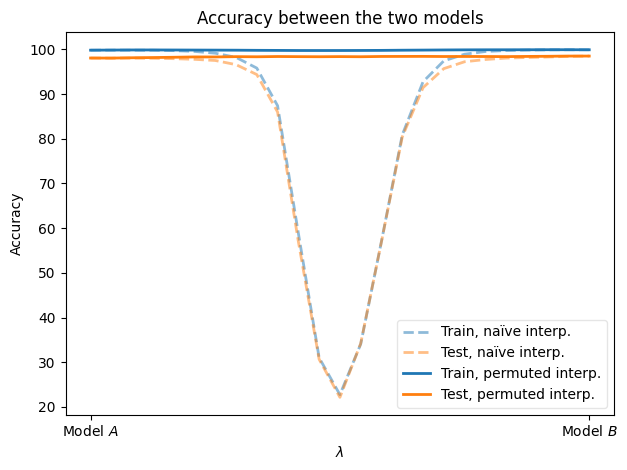

In [ ]:
# from utils.weight_matching import mlp_permutation_spec, weight_matching, apply_permutation
# from utils.utils import flatten_params, lerp
# from utils.plot import plot_interp_acc
import argparse
import torch
from torchvision import datasets, transforms
# from utils.training import test
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt


# parser = argparse.ArgumentParser()
# parser.add_argument("--model_a", type=str, required=True)
# parser.add_argument("--model_b", type=str, required=True)
# parser.add_argument("--seed", type=int, default=0, help="Random seed")
# args = parser.parse_args()


permutation_spec = mlp_permutation_spec(4)
final_permutation = weight_matching(permutation_spec,
                                    flatten_params(model_a_saved), flatten_params(model_b_saved))


updated_params = apply_permutation(permutation_spec, final_permutation, flatten_params(model_b_saved))


# test against mnist
transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])
test_kwargs = {'batch_size': 5000}
train_kwargs = {'batch_size': 5000}
dataset = datasets.MNIST('../data', train=False, download=True,
                  transform=transform)
dataset1 = datasets.MNIST('../data', train=True, download=True,
                  transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)
lambdas = torch.linspace(0, 1, steps=25)

test_acc_interp_clever = []
test_acc_interp_naive = []
train_acc_interp_clever = []
train_acc_interp_naive = []
# naive
model_b_saved.load_state_dict(torch.load("/content/drive/My Drive/mnist_mlp_2.pt"))
model_a_dict = copy.deepcopy(model_a_saved.state_dict())
model_b_dict = copy.deepcopy(model_b_saved.state_dict())
for lam in tqdm(lambdas):
  naive_p = lerp(lam, model_a_dict, model_b_dict)
  model_b_saved.load_state_dict(naive_p)
  test_loss, acc = test(model_b_saved.cuda(), 'cuda', test_loader)
  test_acc_interp_naive.append(acc)
  train_loss, acc = test(model_b_saved.cuda(), 'cuda', train_loader)
  train_acc_interp_naive.append(acc)

# smart
model_b_saved.load_state_dict(updated_params)
model_b_saved.cuda()
model_a_saved.cuda()
model_a_dict = copy.deepcopy(model_a_saved.state_dict())
model_b_dict = copy.deepcopy(model_b_saved.state_dict())
for lam in tqdm(lambdas):
  naive_p = lerp(lam, model_a_dict, model_b_dict)
  model_b_saved.load_state_dict(naive_p)
  test_loss, acc = test(model_b_saved.cuda(), 'cuda', test_loader)
  test_acc_interp_clever.append(acc)
  train_loss, acc = test(model_b_saved.cuda(), 'cuda', train_loader)
  train_acc_interp_clever.append(acc)

fig = plot_interp_acc(lambdas, train_acc_interp_naive, test_acc_interp_naive,
                train_acc_interp_clever, test_acc_interp_clever)
plt.savefig(f"mnist_mlp_weight_matching_interp_accuracy_epoch.png", dpi=300)

In [15]:
device = torch.device("cuda" if use_cuda else "cpu")
class MLP_NON_SYMM(torch.nn.Module):
    def __init__(self, C_matrices, input=28*28):
        super().__init__()
        self.input = input
        self.layer0 = torch.nn.Linear(input, 512)
        self.layer1 = torch.nn.Linear(512, 512)
        self.layer2 = torch.nn.Linear(512, 512)
        self.layer3 = torch.nn.Linear(512, 256)
        self.layer4 = torch.nn.Linear(256, 10)

        self.C0, self.C1, self.C2, self.C3 = C_matrices
        for C in C_matrices:
            C.requires_grad = False

    def forward(self, x):
        x = x.view(-1, self.input)
        x = self.custom_gelu(self.layer0(x), self.C0)
        x = self.custom_gelu(self.layer1(x), self.C1)
        x = self.custom_gelu(self.layer2(x), self.C2)
        x = self.custom_gelu(self.layer3(x), self.C3)
        x = self.layer4(x)
        return F.log_softmax(x, dim=1)

    def custom_gelu(self, x, C):
        return torch.nn.functional.gelu(torch.mm(torch.nn.functional.gelu(x), C))

C_matrices = [
    torch.randn(512, 512).to(device),
    torch.randn(512, 512).to(device),
    torch.randn(512, 512).to(device),
    torch.randn(256, 256).to(device)
]

# model_a = MLP_NON_SYMM(C_matrices=C_matrices).to(device)
# model_b = MLP_NON_SYMM(C_matrices=C_matrices).to(device)

In [18]:
import argparse
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import torch.optim as optim

use_cuda = torch.cuda.is_available()

torch.manual_seed(args_4.seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': args_2.batch_size}
test_kwargs = {'batch_size': args_2.batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model_b = MLP_NON_SYMM(C_matrices=C_matrices).to(device)
optimizer = optim.Adam(model_b.parameters(), lr=args_2.lr)

for epoch in range(1, args_2.epochs + 1):
    train(args_2, model_b, device, train_loader, optimizer, epoch)
    test(model_b, device, test_loader)

# torch.save(model_b.state_dict(), f"mnist_mlp_{str(args_2.seed)}.pt")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b12c9537eb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Epoch: 1 [0/60000 (0%)]	Loss: 1034.189819
Train Epoch: 1 [5120/60000 (8%)]	Loss: 135.230804
Train Epoch: 1 [10240/60000 (17%)]	Loss: 18.806852
Train Epoch: 1 [15360/60000 (25%)]	Loss: 11.745053
Train Epoch: 1 [20480/60000 (34%)]	Loss: 6.606968
Train Epoch: 1 [25600/60000 (42%)]	Loss: 5.083372
Train Epoch: 1 [30720/60000 (51%)]	Loss: 4.156847
Train Epoch: 1 [35840/60000 (59%)]	Loss: 2.906134
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.778599
Train Epoch: 1 [46080/60000 (76%)]	Loss: 1.898797
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.671939
Train Epoch: 1 [56320/60000 (93%)]	Loss: 2.352234
Train Accuracy: (75%) 

Average loss: 1.9795, Accuracy: (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.661496
Train Epoch: 2 [5120/60000 (8%)]	Loss: 1.539505
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.171618
Train Epoch: 2 [15360/60000 (25%)]	Loss: 1.079061
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.313533
Train Epoch: 2 [25600/60000 (42%)]	Loss: 1.907889
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.4

In [19]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(args_3.seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': args_1.batch_size}
test_kwargs = {'batch_size': args_1.batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model_a = MLP_NON_SYMM(C_matrices=C_matrices).to(device)
optimizer = optim.Adam(model_a.parameters(), lr=args_1.lr)

for epoch in range(1, args_1.epochs + 1):
    train(args_1, model_a, device, train_loader, optimizer, epoch)
    test(model_a, device, test_loader)

# torch.save(model_a.state_dict(), f"mnist_mlp_{str(args_1.seed)}.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 940.189331
Train Epoch: 1 [5120/60000 (8%)]	Loss: 120.411385
Train Epoch: 1 [10240/60000 (17%)]	Loss: 19.198910
Train Epoch: 1 [15360/60000 (25%)]	Loss: 11.953046
Train Epoch: 1 [20480/60000 (34%)]	Loss: 6.265797
Train Epoch: 1 [25600/60000 (42%)]	Loss: 4.327809
Train Epoch: 1 [30720/60000 (51%)]	Loss: 3.593540
Train Epoch: 1 [35840/60000 (59%)]	Loss: 2.931265
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.299785
Train Epoch: 1 [46080/60000 (76%)]	Loss: 1.953659
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.425818
Train Epoch: 1 [56320/60000 (93%)]	Loss: 2.747963
Train Accuracy: (74%) 

Average loss: 2.3215, Accuracy: (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.229073
Train Epoch: 2 [5120/60000 (8%)]	Loss: 2.840946
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.630698
Train Epoch: 2 [15360/60000 (25%)]	Loss: 1.918687
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.940716
Train Epoch: 2 [25600/60000 (42%)]	Loss: 1.091477
Train Epoch: 2 [30720/60000 (51%)]	Loss: 1.19

  0%|          | 0/25 [00:00<?, ?it/s]


Average loss: 0.3095, Accuracy: (97%)



  4%|▍         | 1/25 [00:14<05:55, 14.82s/it]


Average loss: 0.0300, Accuracy: (99%)


Average loss: 0.2407, Accuracy: (97%)



  8%|▊         | 2/25 [00:32<06:15, 16.31s/it]


Average loss: 0.0397, Accuracy: (99%)


Average loss: 0.2575, Accuracy: (95%)



 12%|█▏        | 3/25 [00:46<05:40, 15.50s/it]


Average loss: 0.1063, Accuracy: (97%)


Average loss: 0.4352, Accuracy: (89%)



 16%|█▌        | 4/25 [01:03<05:32, 15.84s/it]


Average loss: 0.3351, Accuracy: (91%)


Average loss: 1.0549, Accuracy: (72%)



 20%|██        | 5/25 [01:18<05:15, 15.79s/it]


Average loss: 0.9921, Accuracy: (74%)


Average loss: 2.0150, Accuracy: (53%)



 24%|██▍       | 6/25 [01:33<04:55, 15.56s/it]


Average loss: 1.9757, Accuracy: (54%)


Average loss: 2.6793, Accuracy: (40%)



 28%|██▊       | 7/25 [01:48<04:34, 15.26s/it]


Average loss: 2.6641, Accuracy: (41%)


Average loss: 2.9910, Accuracy: (27%)



 32%|███▏      | 8/25 [02:03<04:16, 15.11s/it]


Average loss: 2.9898, Accuracy: (27%)


Average loss: 3.0315, Accuracy: (17%)



 36%|███▌      | 9/25 [02:18<04:02, 15.16s/it]


Average loss: 3.0386, Accuracy: (17%)


Average loss: 2.9595, Accuracy: (13%)



 40%|████      | 10/25 [02:34<03:51, 15.44s/it]


Average loss: 2.9693, Accuracy: (13%)


Average loss: 2.9024, Accuracy: (11%)



 44%|████▍     | 11/25 [02:49<03:33, 15.28s/it]


Average loss: 2.9107, Accuracy: (11%)


Average loss: 2.8938, Accuracy: (11%)



 48%|████▊     | 12/25 [03:04<03:16, 15.12s/it]


Average loss: 2.8894, Accuracy: (11%)


Average loss: 2.8705, Accuracy: (11%)



 52%|█████▏    | 13/25 [03:18<02:59, 14.96s/it]


Average loss: 2.8621, Accuracy: (11%)


Average loss: 2.8198, Accuracy: (11%)



 56%|█████▌    | 14/25 [03:33<02:44, 14.92s/it]


Average loss: 2.8105, Accuracy: (11%)


Average loss: 2.7484, Accuracy: (12%)



 60%|██████    | 15/25 [03:48<02:28, 14.84s/it]


Average loss: 2.7384, Accuracy: (11%)


Average loss: 2.6609, Accuracy: (12%)



 64%|██████▍   | 16/25 [04:03<02:13, 14.88s/it]


Average loss: 2.6572, Accuracy: (12%)


Average loss: 2.5785, Accuracy: (13%)



 68%|██████▊   | 17/25 [04:18<01:59, 14.97s/it]


Average loss: 2.5819, Accuracy: (14%)


Average loss: 2.4278, Accuracy: (20%)



 72%|███████▏  | 18/25 [04:33<01:45, 15.01s/it]


Average loss: 2.4189, Accuracy: (20%)


Average loss: 2.0598, Accuracy: (31%)



 76%|███████▌  | 19/25 [04:48<01:29, 14.99s/it]


Average loss: 2.0250, Accuracy: (32%)


Average loss: 1.5163, Accuracy: (49%)



 80%|████████  | 20/25 [05:04<01:16, 15.21s/it]


Average loss: 1.4655, Accuracy: (50%)


Average loss: 0.8762, Accuracy: (72%)



 84%|████████▍ | 21/25 [05:19<01:00, 15.07s/it]


Average loss: 0.8204, Accuracy: (73%)


Average loss: 0.4565, Accuracy: (87%)



 88%|████████▊ | 22/25 [05:33<00:44, 14.94s/it]


Average loss: 0.3782, Accuracy: (88%)


Average loss: 0.2822, Accuracy: (94%)



 92%|█████████▏| 23/25 [05:48<00:29, 14.88s/it]


Average loss: 0.1611, Accuracy: (95%)


Average loss: 0.2504, Accuracy: (96%)



 96%|█████████▌| 24/25 [06:03<00:15, 15.02s/it]


Average loss: 0.0727, Accuracy: (98%)


Average loss: 0.2972, Accuracy: (97%)



100%|██████████| 25/25 [06:18<00:00, 15.15s/it]


Average loss: 0.0474, Accuracy: (99%)



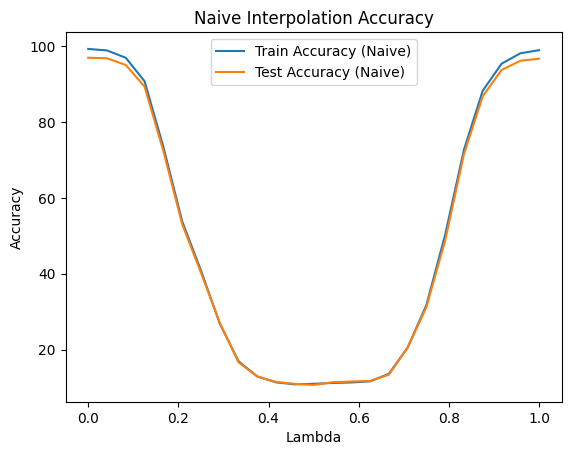

In [20]:
import argparse
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

# Assuming 'test' function and 'lerp' function are defined elsewhere

# Load your models
model_a_saved = model_a
model_b_saved = model_b

# MNIST data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_kwargs = {'batch_size': 5000}
train_kwargs = {'batch_size': 5000}
dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)

# Interpolation
lambdas = torch.linspace(0, 1, steps=25)
test_acc_interp_naive = []
train_acc_interp_naive = []

# Naive interpolation
model_a_dict = copy.deepcopy(model_a_saved.state_dict())
model_b_dict = copy.deepcopy(model_b_saved.state_dict())
for lam in tqdm(lambdas):
    naive_p = lerp(lam, model_a_dict, model_b_dict)
    model_b_saved.load_state_dict(naive_p)
    test_loss, acc = test(model_b_saved.cuda(), 'cuda', test_loader)
    test_acc_interp_naive.append(acc)
    train_loss, acc = test(model_b_saved.cuda(), 'cuda', train_loader)
    train_acc_interp_naive.append(acc)

# Plotting
fig = plt.figure()
plt.plot(lambdas, train_acc_interp_naive, label='Train Accuracy (Naive)')
plt.plot(lambdas, test_acc_interp_naive, label='Test Accuracy (Naive)')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Naive Interpolation Accuracy')
plt.legend()
plt.savefig(f"mnist_mlp_weight_matching_interp_accuracy_epoch_naive.png", dpi=300)
